C:\Users\lg\AppData\Local\Temp\ipykernel_8540\3252685654.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("seg_model.pth", map_location=device)
C

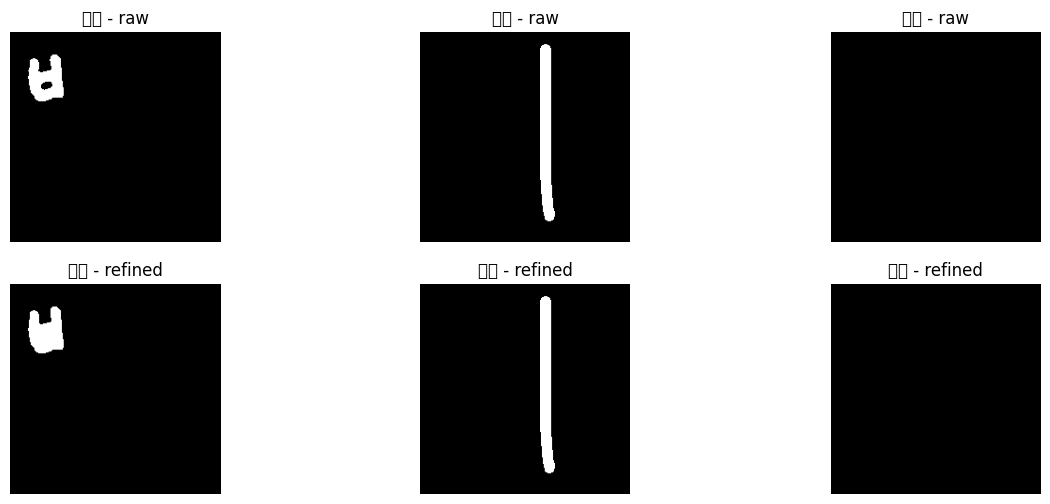

[종성] -> 유효 픽셀이 거의 없음 (건너뜀)


C:\Users\lg\anaconda3\envs\Bitamin_25Winter\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


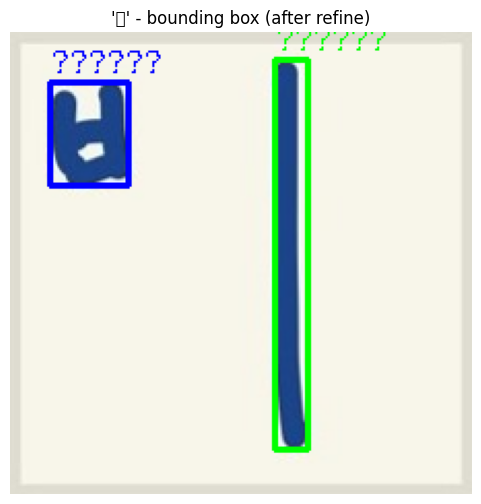

추출된 바운딩박스 좌표: {'초성': (19, 24, 38, 50), '중성': (128, 13, 16, 189), '종성': None}


In [1]:
import torch
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# ---------------------------
# 1) 모델 로딩 (3클래스)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.FPN(encoder_name="resnext50_32x4d", classes=3)
checkpoint = torch.load("seg_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# ---------------------------
# 2) 테스트 이미지 전처리
# ---------------------------
img_path = "unclear_Bi.png"  # "타" 이미지
img = Image.open(img_path).convert("RGB")
img = img.resize((224, 224))
img_np = np.array(img)

gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
_, binary = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY_INV)
binary = binary.astype(np.float32) / 255.0

# 모델 입력은 3채널이어야 하므로, 동일한 이진 이미지를 3채널로 복제
binary_3ch = np.stack([binary, binary, binary], axis=2)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = preprocess(binary_3ch).unsqueeze(0).to(device)

# ---------------------------
# 3) 모델 추론
# ---------------------------
with torch.no_grad():
    output = model(input_tensor)       # (1, 3, 224, 224)
    output = torch.sigmoid(output)
    output_np = output.squeeze(0).cpu().numpy()  # shape: (3, 224, 224)

# ---------------------------
# 4) 마스크 후처리 함수
# ---------------------------
def refine_mask(mask, min_area=50):
    """
    1) 모폴로지 연산(닫힘, 열림)으로 노이즈 제거 및 구멍 메우기
    2) 여러 컨투어가 있으면 모두 합쳐서 boundingRect
    3) 면적이 너무 작은 노이즈는 무시
    최종적으로 (224,224) 이진 마스크로 반환
    """
    # 모폴로지 연산
    kernel = np.ones((3, 3), np.uint8)
    # 닫힘(Closing): 글자 내부 구멍/틈 메움
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    # 열림(Opening): 작은 노이즈 제거
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

    # 유효한 컨투어들만 다시 그려서 최종 mask 생성
    new_mask = np.zeros_like(opened)
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return new_mask  # 아무것도 없으면 빈 mask

    # 모든 컨투어 합치기 (OR 연산) - 단, 너무 작은 노이즈(contourArea < min_area)는 무시
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        cv2.drawContours(new_mask, [cnt], -1, 255, -1)

    return new_mask

# ---------------------------
# 5) 후처리 적용 & 시각화
# ---------------------------
classes = ['초성', '중성', '종성']
seg_masks = (output_np > 0.5).astype(np.uint8) * 255  # (3,224,224)

refined_masks = []
for i in range(3):
    refined = refine_mask(seg_masks[i], min_area=30)  # 필요시 파라미터 조절
    refined_masks.append(refined)

# 후처리 전/후 비교 시각화
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
for i in range(3):
    ax[0, i].imshow(seg_masks[i], cmap='gray')
    ax[0, i].set_title(f"{classes[i]} - raw")
    ax[0, i].axis('off')

    ax[1, i].imshow(refined_masks[i], cmap='gray')
    ax[1, i].set_title(f"{classes[i]} - refined")
    ax[1, i].axis('off')
plt.show()

# ---------------------------
# 6) 바운딩 박스 추출 함수
# ---------------------------
def get_bbox_from_mask(mask):
    """
    refine_mask()로 정제된 마스크에서
    컨투어를 모두 합쳐 최종 bounding box 하나를 추출
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    # 모든 컨투어를 포함하는 바운딩 박스(=합집합)
    # -> 여러 컨투어가 있으면 모두 감싸는 bounding box를 만든다.
    all_points = []
    for cnt in contours:
        all_points.extend(cnt.reshape(-1, 2))
    all_points = np.array(all_points)
    x, y, w, h = cv2.boundingRect(all_points)
    return (x, y, w, h)

# ---------------------------
# 7) 최종 bbox 시각화
# ---------------------------
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
bboxes = {}
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # 채널별 색상(초성,중성,종성)

for i, cls_name in enumerate(classes):
    mask = refined_masks[i]
    if np.count_nonzero(mask) < 10:
        print(f"[{cls_name}] -> 유효 픽셀이 거의 없음 (건너뜀)")
        bboxes[cls_name] = None
        continue

    bbox = get_bbox_from_mask(mask)
    if bbox is not None:
        x, y, w, h = bbox
        bboxes[cls_name] = (x, y, w, h)
        cv2.rectangle(img_cv, (x, y), (x+w, y+h), colors[i], 2)
        cv2.putText(img_cv, cls_name, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 1)
    else:
        bboxes[cls_name] = None

# 결과 시각화 (224x224 이미지 기준)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("'타' - bounding box (after refine)")
plt.axis('off')
plt.show()

# 바운딩박스 좌표
print("추출된 바운딩박스 좌표:", bboxes)


In [2]:
def evaluate_bi_bboxes(bboxes, total_img_size=(224,224)):
    """
    bboxes: {'초성':(x, y, w, h), '중성':(x, y, w, h)} 형태.
    total_img_size: 전체 이미지 크기 (width, height)
    
    조건 (예시):
      1. 초성의 y 좌표는 중성의 y 좌표보다 작아야 함.
         (즉, 초성의 top < 중성의 top)
      2. 초성의 바닥(= y + h)은 중성의 바닥보다 작아야 함.
      3. 초성의 높이(h1)는 중성의 높이(h2)의 0.5 ~ 0.8배여야 함.
      4. 초성의 너비(w1)는 중성의 너비(w2)보다 커야 함.
      5. 초성의 x좌표와 y좌표는 각각 20~70 범위에 있어야 함.
      6. 중성의 x좌표와 y좌표는 각각 110~160, 0~50 범위에 있어야 함.
      7. 초성의 높이는 전체 이미지 높이의 30% ~ 50%여야 함.
      8. 중성의 높이는 전체 이미지 높이의 50% ~ 80%여야 함.
      9. 초성의 너비는 전체 이미지 너비의 15% ~ 40%여야 함.
      10. 중성의 너비는 전체 이미지 너비의 0% ~ 35%여야 함.
      
    반환:
      (bool, messages)
      - 모든 조건이 만족하면 (True, [])
      - 하나라도 불만족이면 (False, [문제 메시지들])
    """
    messages = []
    total_w, total_h = total_img_size

    # 필수 바운딩 박스 존재 확인
    if '초성' not in bboxes or '중성' not in bboxes:
        messages.append("초성과 중성 바운딩 박스가 모두 필요합니다.")
        return False, messages

    x1, y1, w1, h1 = bboxes['초성']
    x2, y2, w2, h2 = bboxes['중성']

    # 조건 1: 초성의 y 좌표는 중성의 y 좌표보다 커야함.
    if not (y1 > y2):
        messages.append(f"초성의 y 좌표 ({y1})가 중성의 y 좌표 ({y2})보다 작거나 같습니다.")
        
    # 조건 2: 초성의 바닥(= y1+h1)은 중성의 바닥(= y2+h2)보다 작아야 함.
    if not ((y1 + h1) < (y2 + h2)):
        messages.append(f"초성의 바닥 ({y1+h1})가 중성의 바닥 ({y2+h2})보다 크거나 같습니다.")
    
    # 조건 3: 초성의 높이는 중성의 높이의 0.5~0.8배여야 함.
    if h2 == 0:
        messages.append("중성의 높이가 0입니다.")
    else:
        ratio_h = h1 / h2
        if not (0.4 <= ratio_h <= 0.8):
            messages.append(f"초성의 높이 비율 ({ratio_h:.2f})가 0.4~0.8 범위를 벗어났습니다.")
    
    # 조건 4: 초성의 너비는 중성의 너비보다 커야 함.
    if not (w1 > w2):
        messages.append(f"초성의 너비 ({w1})가 중성의 너비 ({w2})보다 작거나 같습니다.")
    
    # 조건 5: 초성의 x, y 좌표는 각각 20~70
    if not (20 <= x1 <= 70):
        messages.append(f"초성의 x 좌표 ({x1})가 20~70 범위를 벗어났습니다.")
    if not (20 <= y1 <= 70):
        messages.append(f"초성의 y 좌표 ({y1})가 20~70 범위를 벗어났습니다.")
    
    # 조건 6: 중성의 x, y 좌표는 각각 110~160
    if not (110 <= x2 <= 160):
        messages.append(f"중성의 x 좌표 ({x2})가 110~160 범위를 벗어났습니다.")
    if not (0 <= y2 <= 50):
        messages.append(f"중성의 y 좌표 ({y2})가 0~50 범위를 벗어났습니다.")
    
    # 조건 7: 초성의 높이는 전체 이미지 높이의 30% ~ 50%
    if not (0.3 * total_h <= h1 <= 0.5 * total_h):
        messages.append(f"초성의 높이 ({h1})가 전체 높이 ({total_h})의 30%~50% 범위를 벗어났습니다.")
    
    # 조건 8: 중성의 높이는 전체 이미지 높이의 50% ~ 80%
    if not (0.5 * total_h <= h2 <= 0.8 * total_h):
        messages.append(f"중성의 높이 ({h2})가 전체 높이 ({total_h})의 50%~80% 범위를 벗어났습니다.")
    
    # 조건 9: 초성의 너비는 전체 이미지 너비의 15% ~ 40%
    if not (0.15 * total_w <= w1 <= 0.40 * total_w):
        messages.append(f"초성의 너비 ({w1})가 전체 너비 ({total_w})의 15%~40% 범위를 벗어났습니다.")
    
    # 조건 10: 중성의 너비는 전체 이미지 너비의 0% ~ 35%
    if not (0 <= w2 <= 0.35 * total_w):
        messages.append(f"중성의 너비 ({w2})가 전체 너비 ({total_w})의 0%~35% 범위를 벗어났습니다.")
    
    if messages:
        return False, messages
    else:
        return True, []


In [3]:
is_ok, errors = evaluate_bi_bboxes(bboxes, total_img_size=(224,224))

if is_ok:
    print("글씨가 기준 범위 내에 있습니다!")
else:
    print("글씨가 기준을 벗어났습니다. 문제 항목:")
    for e in errors:
        print(" -", e)

글씨가 기준을 벗어났습니다. 문제 항목:
 - 초성의 높이 비율 (0.26)가 0.4~0.8 범위를 벗어났습니다.
 - 초성의 x 좌표 (19)가 20~70 범위를 벗어났습니다.
 - 초성의 높이 (50)가 전체 높이 (224)의 30%~50% 범위를 벗어났습니다.
 - 중성의 높이 (189)가 전체 높이 (224)의 50%~80% 범위를 벗어났습니다.
